# Compute time series from the ECCOv4r4 runs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pych

In [2]:
uvel = xr.open_dataarray('../ncfiles/eccov4r4_uvel.nc').sortby(['time','depth','lon'])

## 1. Core speed = max velocity over depth

In [3]:
uMax = uvel.max('depth')
uMax.name = 'Core Speed'
uMax.attrs['description'] = 'Maximum speed at time interval and longitude'
uMax.attrs['units'] = 'm/s'

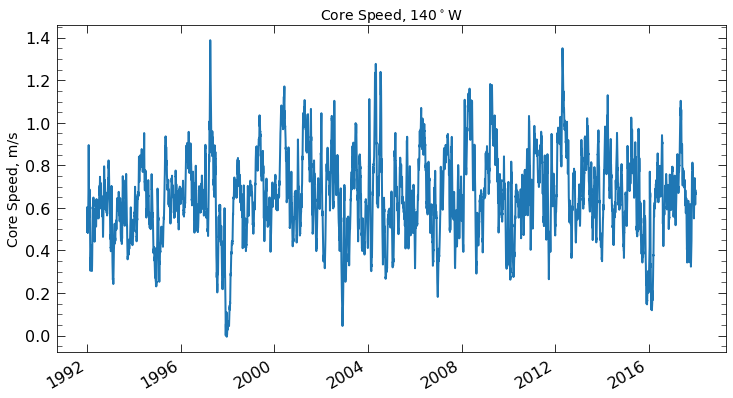

In [4]:
fig,ax = plt.subplots(figsize=(12,6))
uMax.sel(lon=-140).plot(ax=ax)
pych.nice_inward_ticks(ax=ax,yminor_skip=.05)
ax.set(title=r'Core Speed, 140$^\circ$W',ylabel='Core Speed, m/s',xlabel='');

## 2. Core depth: depth of max speed

In [5]:
depthMax = xr.zeros_like(uMax)
depthMax.name = 'Core Depth'
depthMax.attrs['description'] = 'Depth of maximum speed at time interval and longitude'
depthMax.attrs['units'] = 'm'

In [6]:
with xr.set_options(keep_attrs=True):
    depthtime = uvel.depth.broadcast_like(uvel.time)
    for lon in uvel.lon.values:
        ind = np.argmax(uvel.sel(lon=lon),axis=1)
        depthMax.loc[{'lon':lon}] = xr.where(depthtime[:,ind]>400,400,depthtime[:,ind])

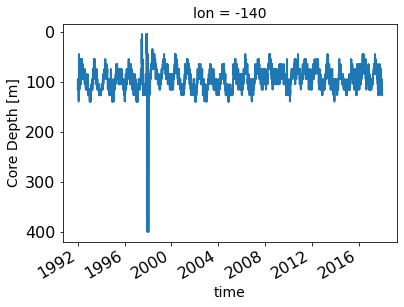

In [7]:
depthMax.sel(lon=-140).plot(yincrease=False)

## 3. Core thickness: distance in depth over which velocity is positive

Here, linearly interpolate to approximate the zero crossing

### Example indices for edge cases:
- time index 50: lower portion does not cross zero, in this case, take depth of minimum velocity
- time index 60* 24: is a good case
- time index 80 * 24: lower half goes negative then positive
- time index 25 * 24: upper half never goes positive

In [8]:
def get_bounding_depths(uprof,coredepth):
    
    uvelUpperHalf = get_crossing_depth(uprof.where(uprof.depth<coredepth,drop=True),True)
    uvelLowerHalf = get_crossing_depth(uprof.where(uprof.depth>coredepth,drop=True),False)
    return uvelUpperHalf,uvelLowerHalf

In [9]:
def get_crossing_depth(half_profile,isUpper):
    half_index = np.argsort(np.abs(half_profile))
    posInd = half_profile>0
    negInd = half_profile<0
    myrolls = [-1,1] if isUpper else [1,-1]
    
    # indices where positive and negative values are neighbors
    negSel = posInd.shift({'depth':myrolls[0]},False) & negInd
    posSel = negInd.shift({'depth':myrolls[1]},False) & posInd
    
    
    uNeg = half_profile.where(negSel)
    uPos = half_profile.where(posSel)
    dNeg = half_profile.depth.where(negSel)
    dPos = half_profile.depth.where(posSel)
    
    deltaD = (dPos - dNeg.shift({'depth':myrolls[1]},np.NAN)).sum('depth')
    deltaU = np.abs(half_profile.where(negSel | posSel)).sum('depth')
    
    dZero = dNeg - deltaD * (uNeg/deltaU) 
    depth_min = 0. if isUpper else 400
    depth_min = depth_min*xr.ones_like(half_profile).where(half_profile.depth==half_profile.depth[0])
    result = xr.where((negSel | posSel).any('depth'),dZero,depth_min).sum('depth')
    
    return xr.where(result>400,400,result)

### Compute upper, lower bounds

In [10]:
up,lo = get_bounding_depths(uvel,depthMax)

### Threshold core speed by 10 cm/s

In [13]:
uvel.lon

<xarray.DataArray 'lon' (lon: 6)>
array([-170, -140, -110,  147,  156,  165])
Coordinates:
  * lon      (lon) int64 -170 -140 -110 147 156 165

In [17]:
lon=147
threshold=.1
cond1 = uMax>threshold
cond2 = depthMax<lo
cond3 = depthMax>up
mycond = cond1&cond2&cond3

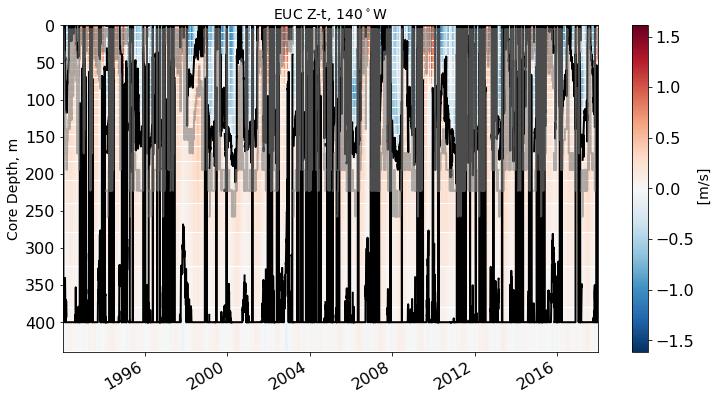

In [18]:
fig,ax = plt.subplots(1,1,figsize=(12,6))

uvel.sel(lon=lon).plot(ax=ax,y='depth',yincrease=False)
up.where(mycond).sel(lon=lon).plot(ax=ax,color='black')
lo.where(mycond).sel(lon=lon).plot(ax=ax,color='black')
depthMax.where(mycond).sel(lon=lon).plot(ax=ax,color='gray',alpha=.6)
#ax.set(xlim=['1997-10-25','1998-02-01'])
#ax.set(xlim=['1996-05-25','2000-02-01'])
ax.set(title='EUC Z-t, 140$^\circ$W',xlabel='',ylabel='Core Depth, m');
#fig.savefig('../figures/eccov4r4_uvel_hourly_140W.png',bbox_inches='tight',dpi=300)

### Edge cases for upper core depth
- at '1992-01-28T12', neither upper or lower cross zero (all positive). 
    o upper: grab minimum which is *not* the highest depth, but does seem to be intuitively what we would consider to be the upper bound of the "core" 
- at '1992-01-25T12', neither upper or lower cross zero (all positive). 
    o upper: grab minimum which is neither the highest depth, nor is it the first point where the curvature changes, and so it seems less like the "core bounds"

In [14]:
plt.rcParams.update({'lines.markersize':10})

Text(0.5, 0.95, 'ECCOv4r4 Hourly Zonal Velocity Profiles\nShowing various core thickness cases')

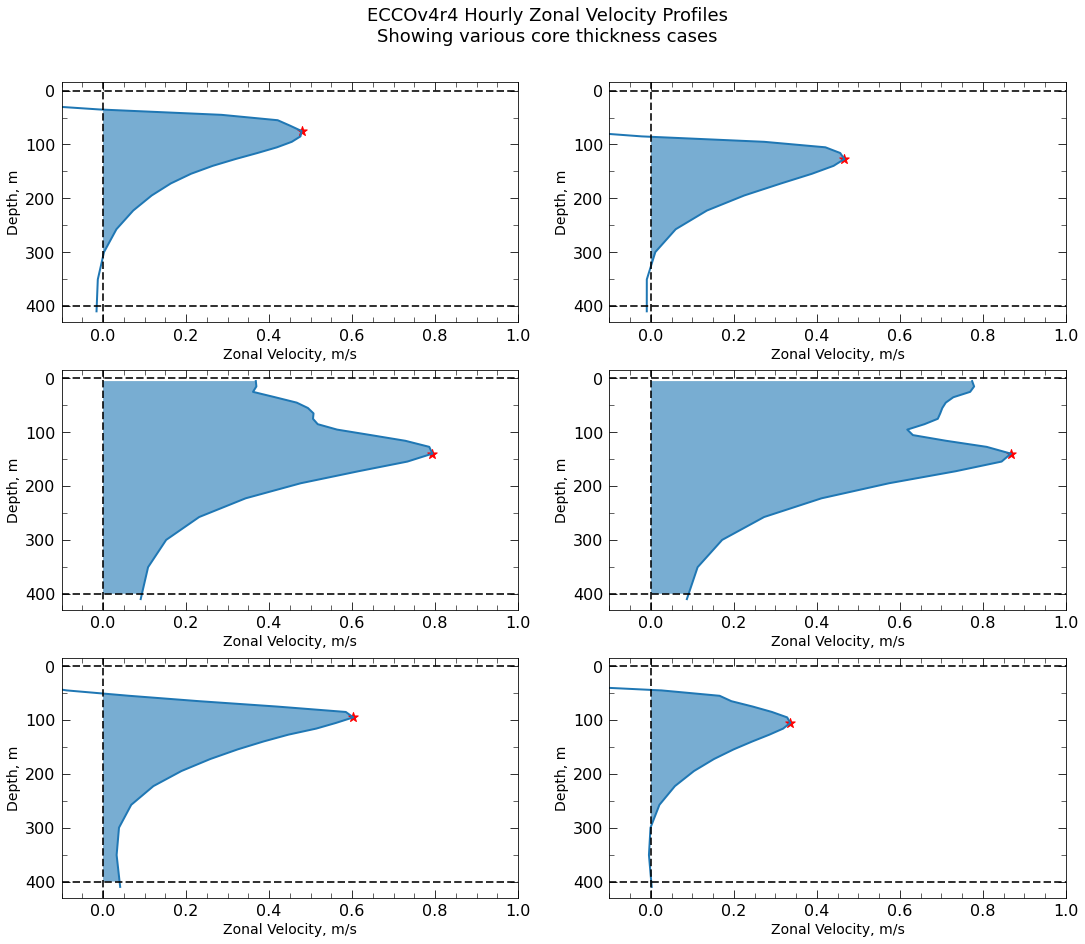

In [15]:
fig,axs = plt.subplots(3,2,figsize=(18,5*3))
times = ['1992-05-01T12','1993-01-01T12','1992-01-25T12','1992-01-28T12','1992-01-03T15','1992-03-21T13']
for tt,ax in zip(times,axs.flatten()):
    
    # The upper, core, and lower depths
    uu = uvel.sel(lon=lon,time=tt)
    uu.plot(y='depth',yincrease=False,ax=ax)
    cond = (uu>0) & (uu.depth<400) & (uu.depth>0)
    mydepth = np.concatenate([[up.sel(lon=lon,time=tt).values],uu.depth.where(cond,drop=True).values,
                              [lo.sel(lon=lon,time=tt).values]])
    myvel = np.concatenate([[uu.interp(depth=up.sel(lon=lon,time=tt)).values],
                            uu.where(cond,drop=True),
                            [uu.interp(depth=lo.sel(lon=lon,time=tt)).values]])
    ax.fill_betweenx(y=mydepth,x1=0*myvel,x2=myvel,alpha=.6)
    ax.scatter(uMax.sel(lon=lon,time=tt),depthMax.sel(lon=lon,time=tt),marker='*',color='red')
    
    # Define the bounds of what we consider
    ax.axhline(0,color='black',alpha=.8,linestyle='--')
    ax.axhline(400,color='black',alpha=.8,linestyle='--')
    ax.axvline(0,color='black',alpha=.8,linestyle='--')
    ax.set(xlim=[-.1,1],title='',ylabel='Depth, m',xlabel='Zonal Velocity, m/s')
    pych.nice_inward_ticks(ax=ax,xminor_skip=.05,yminor_skip=50)
fig.suptitle('ECCOv4r4 Hourly Zonal Velocity Profiles\nShowing various core thickness cases',fontsize=18,y=.95)
#fig.savefig('../figures/eccov4r4_uvel_profiles_140W.png',dpi=300,bbox_inches='tight')

### Some plots

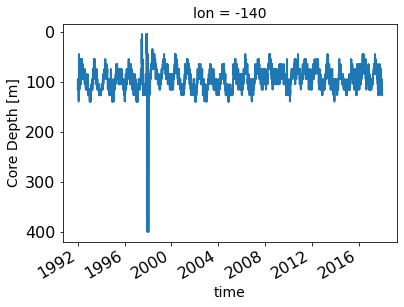

In [16]:
depthMax.sel(lon=-140).plot(yincrease=False)